<a href="https://colab.research.google.com/github/RodrigoCharalla/proyecto-titanic/blob/main/ml_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalación y llamado de paquetes

In [3]:
 install.packages(c("tidyverse", "caret","ggpubr",
                  "titanic","randomForest","doMC","recipes"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#install.packages("caret")

In [ ]:
#install.packages("ggpubr")

In [ ]:
#install.packages("tidyverse")

In [ ]:
#install.packages("titanic")

In [ ]:
#install.packages("randomForest")

In [ ]:
#install.packages("doMC")

In [ ]:
#install.packages("recipes")

In [ ]:
packages <- c("tidyverse", "caret", "ggpubr", "titanic", "randomForest", "doMC", "recipes")
lapply(packages, library, character.only = TRUE)

In [ ]:
library(caret)

#Dataset Titanic

In [ ]:
library(tidyverse)
library(titanic)
datos <- titanic_train

#Análisis exploratorio de los datos




* **PassengerId:** identificador único del pasajero.

* **Survived:** si el pasajero sobrevivió al naufragio, codificada como 0 (no) y 1 (si). Esta es la variable respuesta que interesa predecir.

* **Pclass:** clase a la que pertenecía el pasajero: 1, 2 o 3.

* **Name:** nombre del pasajero.

* **Sex:** sexo del pasajero.

* **Age:** edad del pasajero.

* **SibSp:** número de hermanos, hermanas, hermanastros o hermanastras en el barco.

* **Parch:** número de padres e hijos en el barco.

* **Ticket:** identificador del billete.

* **Fare:** precio pagado por el billete.

* **Cabin:** identificador del camarote asignado al pasajero.

* **Embarked:** puerto en el que embarcó el pasajero.

## Tipo de variables


In [ ]:
# Resumen del set de datos
glimpse(datos)

Rows: 891
Columns: 12
$ PassengerId <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…
$ Survived    <int> 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1…
$ Pclass      <int> 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3…
$ Name        <chr> "Braund, Mr. Owen Harris", "Cumings, Mrs. John Bradley (Fl…
$ Sex         <chr> "male", "female", "female", "female", "male", "male", "mal…
$ Age         <dbl> 22, 38, 26, 35, 35, NA, 54, 2, 27, 14, 4, 58, 20, 39, 14, …
$ SibSp       <int> 1, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 1, 0, 0, 4, 0, 1, 0…
$ Parch       <int> 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 5, 0, 0, 1, 0, 0, 0…
$ Ticket      <chr> "A/5 21171", "PC 17599", "STON/O2. 3101282", "113803", "37…
$ Fare        <dbl> 7.2500, 71.2833, 7.9250, 53.1000, 8.0500, 8.4583, 51.8625,…
$ Cabin       <chr> "", "C85", "", "C123", "", "", "E46", "", "", "", "G6", "C…
$ Embarked    <chr> "S", "C", "S", "S", "S", "Q", "S", "S", "S", "C", "S", "S"…


In [ ]:
datos$Survived <- if_else(datos$Survived == 1, "Si", "No")
datos$Survived <- as.factor(datos$Survived)

In [ ]:
datos$Pclass <- as.factor(datos$Pclass)

In [ ]:
datos$SibSp <- as.factor(datos$SibSp)
datos$Parch <- as.factor(datos$Parch)

In [ ]:
datos$Sex      <- as.factor(datos$Sex)
datos$Embarked <- as.factor(datos$Embarked)

In [ ]:
datos_long <- datos %>% gather(key = "variable", value = "valor", -PassengerId)
head(datos_long)

Warning message:
“attributes are not identical across measure variables; they will be dropped”


,PassengerId,variable,valor
,<int>,<chr>,<chr>
1,1,Survived,No
2,2,Survived,Si
3,3,Survived,Si
4,4,Survived,Si
5,5,Survived,No
6,6,Survived,No


## Número de observaciones y valores ausentes

In [ ]:
# Número de observaciones del set de datos
nrow(datos)

[1] 891

In [ ]:
# Detección si hay alguna fila incompleta
any(!complete.cases(datos))

[1] TRUE

In [ ]:
# Número de datos ausentes por variable
map_dbl(datos, .f = function(x){sum(is.na(x))})

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0           0           0

In [ ]:
datos %>% map_lgl(.f = function(x){any(!is.na(x) & x == "")})

PassengerId    Survived      Pclass        Name         Sex         Age 
      FALSE       FALSE       FALSE       FALSE       FALSE       FALSE 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
      FALSE       FALSE       FALSE       FALSE        TRUE        TRUE

In [ ]:
# La variable Cabin está almacenada como character
datos$Cabin[datos$Cabin == ""] <- NA

In [ ]:
levels(datos$Embarked)

[1] ""  "C" "Q" "S"

In [ ]:
datos$Embarked <- as.character(datos$Embarked)
datos$Embarked[datos$Embarked == ""] <- NA
datos$Embarked <- as.factor(datos$Embarked)
levels(datos$Embarked)

[1] "C" "Q" "S"

In [ ]:
# Este cambio también se aplica al dataframe datos_long
datos_long$valor[datos_long$valor == ""] <- NA

In [ ]:
# Número de datos ausentes por variable
map_dbl(datos, .f = function(x){sum(is.na(x))})

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0         687           2

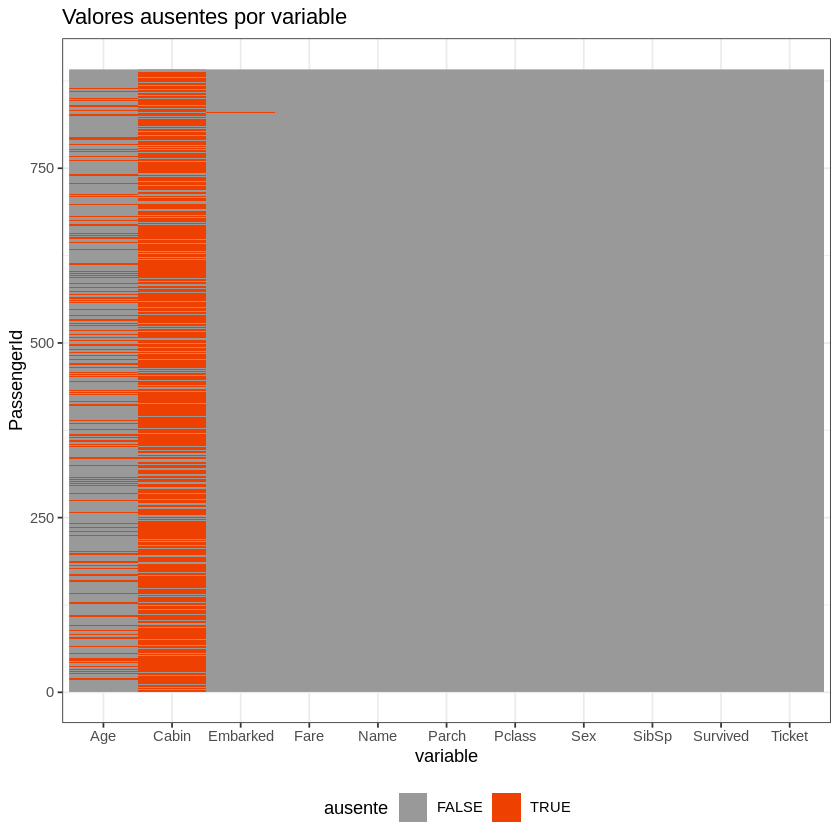

In [ ]:
# Representación gráfica de los datos ausentes
datos_long <- datos_long %>%  mutate(ausente = is.na(valor))
ggplot(data = datos_long, aes(x = variable,
                              y = PassengerId,
                              fill = ausente)) +
  geom_raster() +
  scale_fill_manual(values = c("gray60", "orangered2")) +
  theme_bw() +
  labs(title = "Valores ausentes por variable") +
  theme(legend.position = "bottom")

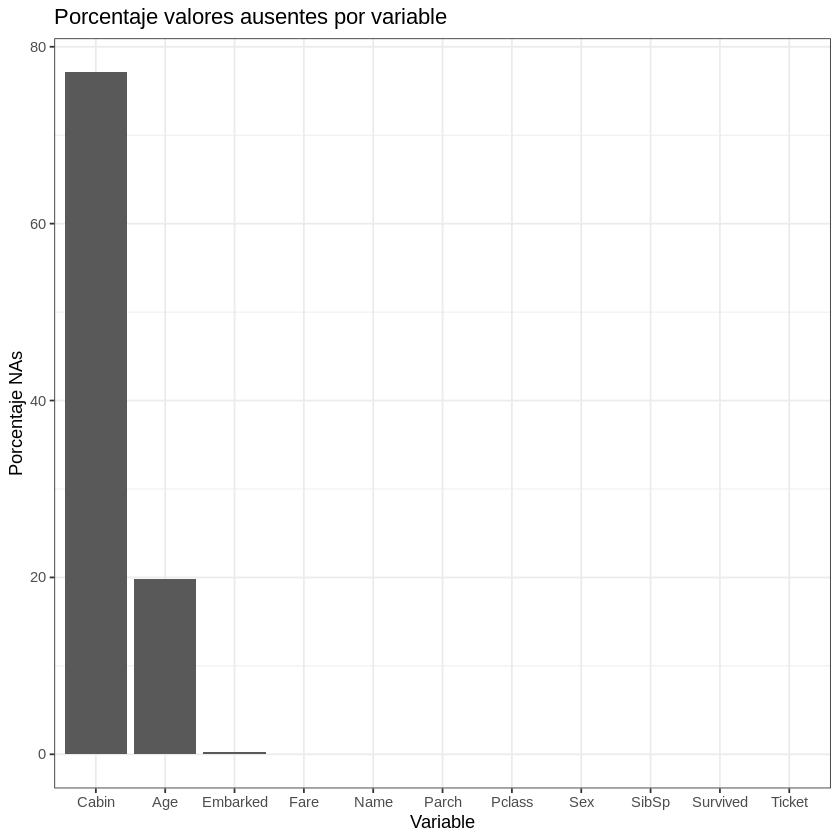

In [ ]:
datos_long %>%
  group_by(variable) %>%
  summarize(porcentaje_NA = 100 * sum(is.na(valor)) / length(valor)) %>%
  ggplot(aes(x = reorder(variable, desc(porcentaje_NA)), y = porcentaje_NA)) +
    geom_col() +
    labs(title = "Porcentaje valores ausentes por variable",
         x = "Variable", y = "Porcentaje NAs") +
    theme_bw()

## Distribución de variables respuesta

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


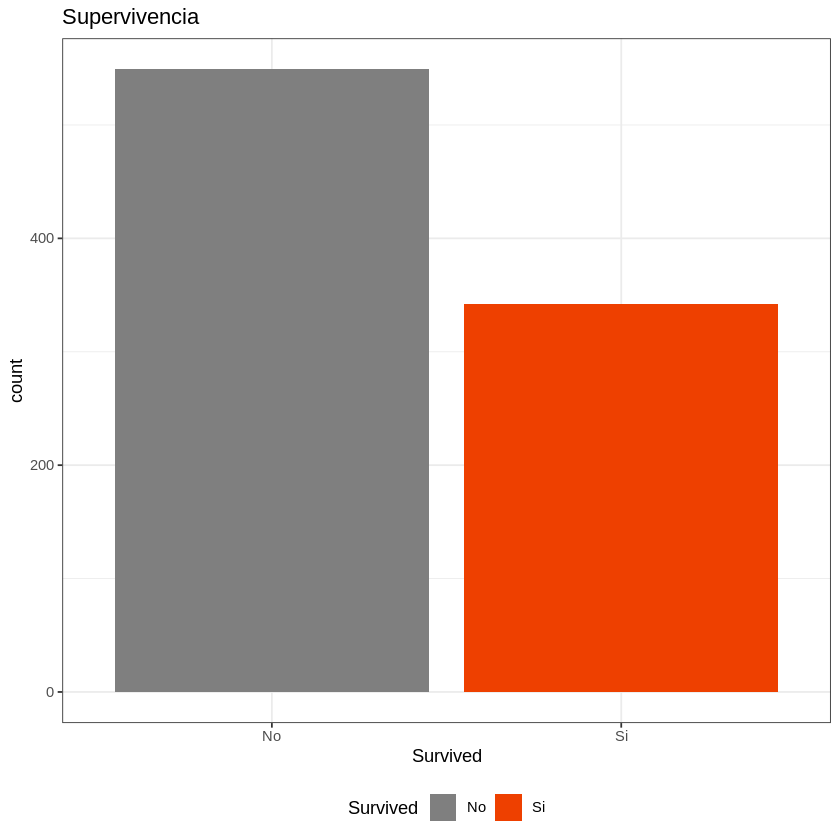

In [ ]:
ggplot(data = datos, aes(x = Survived, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Supervivencia") +
  theme_bw() +
  theme(legend.position = "bottom")

In [ ]:
# Tabla de frecuencias
table(datos$Survived)


 No  Si 
549 342 

In [ ]:
prop.table(table(datos$Survived)) %>% round(digits = 2)


  No   Si 
0.62 0.38 

In [ ]:
# Porcentaje de aciertos si se predice para todas las observaciones que
#no sobrevivieron.
n_observaciones <- nrow(datos)
predicciones <- rep(x = "No",  n_observaciones)
mean(predicciones == datos$Survived) * 100

[1] 61.61616

## Distribución de variables continuas

In [ ]:
library(ggpubr)
p1 <- ggplot(data = datos, aes(x = Age, fill = Survived)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2")) +
      geom_rug(aes(color = Survived), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
p2 <- ggplot(data = datos, aes(x = Survived, y = Age, color = Survived)) +
      geom_boxplot(outlier.shape = NA) +
      geom_jitter(alpha = 0.3, width = 0.15) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
final_plot <- ggarrange(p1, p2, legend = "top")
final_plot <- annotate_figure(final_plot, top = text_grob("Age", size = 15))
final_plot

ERROR: Error in library(ggpubr): there is no package called ‘ggpubr’


In [ ]:
# Estadísticos de la edad de los supervivientes y fallecidos
datos %>% filter(!is.na(Age)) %>% group_by(Survived) %>%
          summarise(media = mean(Age),
                    mediana = median(Age),
                    min = min(Age),
                    max = max(Age))

In [ ]:
datos <- datos %>%
         mutate(Age_grupo = case_when(Age <= 10  ~ "niño",
                                      Age > 10 & Age <= 60  ~ "adulto",
                                      Age > 60 ~ "anciano"))
datos$Age_grupo <- as.factor(datos$Age_grupo)

In [ ]:
p1 <- ggplot(data = datos, aes(x = Fare, fill = Survived)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2")) +
      geom_rug(aes(color = Survived), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
p2 <- ggplot(data = datos, aes(x = Survived, y = Fare, color = Survived)) +
      geom_boxplot(outlier.shape = NA) +
      geom_jitter(alpha = 0.3, width = 0.15) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
final_plot <- ggarrange(p1, p2, legend = "top")
final_plot <- annotate_figure(final_plot, top = text_grob("Fare", size = 15))
final_plot

In [ ]:
# Estadísticos del precio del billete de los supervivientes y fallecidos
datos %>% filter(!is.na(Fare)) %>% group_by(Survived) %>%
          summarise(media = mean(Fare),
                    mediana = median(Fare),
                    min = min(Fare),
                    max = max(Fare))

In [ ]:
p1 <- ggplot(data = datos, aes(x = log(Fare), fill = Survived)) +
      geom_density(alpha = 0.5) +
      scale_fill_manual(values = c("gray50", "orangered2")) +
      geom_rug(aes(color = Survived), alpha = 0.5) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
p2 <- ggplot(data = datos, aes(x = Survived, y = log(Fare), color = Survived)) +
      geom_boxplot(outlier.shape = NA) +
      geom_jitter(alpha = 0.3, width = 0.15) +
      scale_color_manual(values = c("gray50", "orangered2")) +
      theme_bw()
final_plot <- ggarrange(p1, p2, legend = "top")
final_plot <- annotate_figure(final_plot, top = text_grob("Log(Fare)", size =15))
final_plot

## Distribución de variables cualitativas

In [ ]:
ggplot(data = datos, aes(x = Pclass, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Pclass") +
  theme_bw() +
  theme(legend.position = "bottom")

In [ ]:
# Tabla de frecuencias relativas de supervivientes por clase
prop.table(table(datos$Pclass, datos$Survived), margin = 1) %>% round(digits = 2)

In [ ]:
ggplot(data = datos, aes(x = Sex, y = ..count.., fill = Survived)) +
  geom_bar() +
  labs(title = "Sex") +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  theme_bw() +
  theme(legend.position = "bottom")

In [ ]:
# Tabla de frecuencias relativas de supervivientes por sexo
prop.table(table(datos$Sex, datos$Survived), margin = 1) %>% round(digits = 2)

In [ ]:
ggplot(data = datos, aes(x = SibSp, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "SibSp") +
  theme_bw() +
  theme(legend.position = "bottom")

In [ ]:
# Tabla de frecuencias relativas de supervivientes por número de familiares
prop.table(table(datos$SibSp, datos$Survived), margin = 1) %>% round(digits = 2)

In [ ]:
ggplot(data = datos, aes(x = Parch, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Parch") +
  theme_bw() +
  theme(legend.position = "bottom")

In [ ]:
# Tabla de frecuencias relativas de supervivientes por Parch
prop.table(table(datos$Parch, datos$Survived), margin = 1) %>% round(digits = 2)

In [ ]:
# Para pasar de factor a numeric primero se convierte a character
datos$SibSp <- as.character(datos$SibSp)
datos$SibSp <- as.numeric(datos$SibSp)
datos$Parch <- as.character(datos$Parch)
datos$Parch <- as.numeric(datos$Parch)

In [ ]:
ggplot(data = datos, aes(x = Embarked, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Embarked") +
  theme_bw() +
  theme(legend.position = "bottom")

In [ ]:
# Tabla de frecuencias relativas de supervivientes por puerto de embarque
prop.table(table(datos$Embarked, datos$Survived), margin = 1) %>% round(digits = 2)

In [ ]:
ggplot(data = datos, aes(x = Age_grupo, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Age_grupo") +
  theme_bw() +
  theme(legend.position = "bottom")

In [ ]:
# Tabla de frecuencias relativas de supervivientes por grupo de edad
prop.table(table(datos$Age_grupo, datos$Survived), margin = 1) %>% round(digits = 2)

## Importancia de las variables

### Correlación entre variables continuas

In [ ]:
cor.test(x = datos$Age, y = datos$Fare, method = "pearson")

In [ ]:
ggplot(data = datos, aes(x = Age, y = log(Fare))) +
  geom_point(color = "gray30") +
  geom_smooth(color = "firebrick") +
  theme_bw()


### Contraste de proporciones

In [ ]:
ggplot(data = datos, aes(x = Age_grupo, y = ..count.., fill = Survived)) +
  geom_bar() +
  scale_fill_manual(values = c("gray50", "orangered2")) +
  labs(title = "Age_grupo") +
  theme_bw() +
  theme(legend.position = "bottom")

In [ ]:
# Se excluyen las variables continuas y las cualitativas que no agrupan a los
# pasajeros. También la variable Cabin por su alto % de valores NA.
datos_cualitativos <- datos %>%
                      select(-Age, -Fare, -Name, -Ticket, -Cabin, -PassengerId)

datos_cualitativos_tidy <- datos_cualitativos %>%
                           gather(key = "variable", value = "grupo",-Survived)

# Se eliminan los valores NA para que no se interpreten como un grupo
datos_cualitativos_tidy <- datos_cualitativos_tidy %>% filter(!is.na(grupo))

# Se añade un identificador formado por el nombre de la variable y el grupo
datos_cualitativos_tidy <- datos_cualitativos_tidy %>%
                           mutate(variable_grupo = paste(variable, grupo, sep = "_"))

In [ ]:
# Función que calcula el test de proporciones para la columna "Survived" de un df
test_proporcion <- function(df){
  n_supervivientes <- sum(df$Survived == "Si")
  n_fallecidos     <- sum(df$Survived == "No")
  n_total <- n_supervivientes + n_fallecidos
  test <- prop.test(x = n_supervivientes, n = n_total, p = 0.3838)
  prop_supervivientes <- n_supervivientes / n_total
  return(data.frame(p_value = test$p.value, prop_supervivientes))
}

# Se agrupan los datos por "variable_grupo" y se aplica a cada grupo la función
# test_proporcion()
analisis_prop <- datos_cualitativos_tidy %>%
                 group_by(variable_grupo) %>%
                 nest() %>%
                 arrange(variable_grupo) %>%
                 mutate(prop_test = map(.x = data, .f = test_proporcion)) %>%
                 unnest(prop_test) %>%
                 arrange(p_value) %>%
                 select(variable_grupo,p_value, prop_supervivientes)
analisis_prop

In [ ]:
# Representación gráfica de la distribución de los 6 grupos con menor p-value
top6_grupos <- analisis_prop %>% pull(variable_grupo) %>% head(6)

# Se crea una función que, dados un dataframe y el nombre de un grupo, genere la
# representación gráfica de supervivientes y no supervivientes.
plot_grupo <- function(grupo, df, threshold_line = 0.3838){

  p <- ggplot(data = df, aes(x = 1, y = ..count.., fill = Survived)) +
            geom_bar() +
            scale_fill_manual(values = c("gray50", "orangered2")) +
            # Se añade una línea horizontal en el nivel basal
            geom_hline(yintercept = nrow(df) * threshold_line,
                       linetype = "dashed") +
            labs(title = grupo) +
            theme_bw() +
            theme(legend.position = "bottom",
                  axis.text.x = element_blank(),
                  axis.title.x = element_blank(),
                  axis.ticks.x = element_blank())
  return(p)
}

datos_graficos <- datos_cualitativos_tidy %>%
                  filter(variable_grupo %in% top6_grupos) %>%
                  group_by(variable_grupo) %>%
                  nest() %>%
                  arrange(variable_grupo)

plots <- map2(datos_graficos$variable_grupo, .y = datos_graficos$data,
              .f = plot_grupo)

ggarrange(plotlist = plots, common.legend = TRUE)



### Random forest

In [ ]:
library(randomForest)
datos_rf <- datos %>%
            select(-PassengerId, -Name, -Ticket, -Cabin, -Age, -Age_grupo) %>%
            na.omit()
datos_rf <- map_if(.x = datos_rf, .p = is.character, .f = as.factor) %>%
            as.data.frame()
modelo_randforest <- randomForest(formula = Survived ~ . ,
                                  data = na.omit(datos_rf),
                                  mtry = 5,
                                  importance = TRUE,
                                  ntree = 1000)
importancia <- as.data.frame(modelo_randforest$importance)
importancia <- rownames_to_column(importancia,var = "variable")

p1 <- ggplot(data = importancia, aes(x = reorder(variable, MeanDecreaseAccuracy),
                               y = MeanDecreaseAccuracy,
                               fill = MeanDecreaseAccuracy)) +
      labs(x = "variable", title = "Reducción de Accuracy") +
      geom_col() +
      coord_flip() +
      theme_bw() +
      theme(legend.position = "bottom")

p2 <- ggplot(data = importancia, aes(x = reorder(variable, MeanDecreaseGini),
                               y = MeanDecreaseGini,
                               fill = MeanDecreaseGini)) +
      labs(x = "variable", title = "Reducción de pureza (Gini)") +
      geom_col() +
      coord_flip() +
      theme_bw() +
      theme(legend.position = "bottom")
ggarrange(p1, p2)

# División de los datos en entrenamiento y test

In [ ]:
set.seed(123)
# Se crean los índices de las observaciones de entrenamiento
train <- createDataPartition(y = datos$Survived, p = 0.8, list = FALSE, times = 1)
datos_train <- datos[train, ]
datos_test  <- datos[-train, ]

In [ ]:
prop.table(table(datos_train$Survived))

In [ ]:
prop.table(table(datos_test$Survived))

# Preprocesado de los datos


## Imputación de valores ausentes


In [ ]:
nrow(datos)

In [ ]:
nrow(na.omit(datos))

In [ ]:
datos_train <- datos_train %>%
               mutate(Embarked = replace(Embarked, is.na(Embarked), "C"))
datos_test <-  datos_test %>%
               mutate(Embarked = replace(Embarked, is.na(Embarked), "C"))

In [ ]:
library(recipes)
# Se crea un objeto recipe() con la variable respuesta y los predictores.
# Las variables *PassengerId*, *Name*, *Ticket* no parecen aportar información
# relevante sobre la supervivencia de los pasajeros. Excluyendo todas estas
# variables, se propone como modelo inicial el formado por los predictores:
#  Pclass + Sex + SibSp + Parch + Fare + Embarked + Age_grupo.

objeto_recipe <- recipe(formula = Survived ~ Pclass + Sex + SibSp + Parch +
                                  Fare + Embarked + Age_grupo,
                        data =  datos_train)
objeto_recipe

In [ ]:
objeto_recipe <- objeto_recipe %>% step_bagimpute(Age_grupo)
objeto_recipe

## Variables con varianza próxima a cero

In [ ]:
datos %>% select(Pclass, Sex, SibSp, Parch, Fare, Embarked, Age_grupo) %>%
          nearZeroVar(saveMetrics = TRUE)

In [ ]:
objeto_recipe <- objeto_recipe %>% step_nzv(all_predictors())

## Estandarización y escalado

In [ ]:
objeto_recipe <- objeto_recipe %>% step_center(all_numeric())
objeto_recipe <- objeto_recipe %>% step_scale(all_numeric())

## Binarización de variables cualitativas

In [ ]:
objeto_recipe <- objeto_recipe %>% step_dummy(all_nominal(), -all_outcomes())

In [ ]:
# Se entrena el objeto recipe
trained_recipe <- prep(objeto_recipe, training = datos_train)
trained_recipe

In [ ]:
# Se aplican las transformaciones al conjunto de entrenamiento y de test
datos_train_prep <- bake(trained_recipe, new_data = datos_train)
datos_test_prep  <- bake(trained_recipe, new_data = datos_test)

glimpse(datos_train_prep)

## Selección de predictores

### Métodos wrapper

#### Eliminación recursiva de variables

In [ ]:
# ELIMINACIÓN RECURSIVA MEDIANTE RANDOM FOREST Y BOOTSTRAPPING
# =============================================================================

# Se paraleliza el proceso para que sea más rápido. El número de cores debe
# seleccionarse en función del ordenador que se está empleando.
library(doMC)
registerDoMC(cores = 4)

# Tamaño de los conjuntos de predictores analizados
subsets <- c(3:11)

# Número de resamples para el proceso de bootstrapping
repeticiones <- 30

# Se crea una semilla para cada repetición de validación. Esto solo es necesario si
# se quiere asegurar la reproducibilidad de los resultados, ya que la validación
# cruzada y el bootstrapping implican selección aleatoria.

# El número de semillas necesarias depende del número total de repeticiones:
# Se necesitan B+1 elementos donde B es el número total de particiones (CV) o
# resampling (bootstrapping). Los primeros B elementos deben ser vectores formados
# por M números enteros, donde M es el número de modelos ajustados, que en este caso
# se corresponde con el número de tamaños. El último elemento solo necesita un único
# número para ajustar el modelo final.
set.seed(123)
seeds <- vector(mode = "list", length = repeticiones + 1)
for (i in 1:repeticiones) {
  seeds[[i]] <- sample.int(1000, length(subsets))
}
seeds[[repeticiones + 1]] <- sample.int(1000, 1)

# Se crea un control de entrenamiento donde se define el tipo de modelo empleado
# para la selección de variables, en este caso random forest, la estrategia de
# resampling, en este caso bootstrapping con 30 repeticiones, y las semillas para
# cada repetición. Con el argumento returnResamp = "all" se especifica que se
# almacene la información de todos los modelos generados en todas las repeticiones.
ctrl_rfe <- rfeControl(functions = rfFuncs, method = "boot", number = repeticiones,
                       returnResamp = "all", allowParallel = TRUE, verbose = FALSE,
                       seeds = seeds)

# Se ejecuta la eliminación recursiva de predictores
set.seed(342)
rf_rfe <- rfe(Survived ~ ., data = datos_train_prep,
              sizes = subsets,
              metric = "Accuracy",
              # El accuracy es la proporción de clasificaciones correctas
              rfeControl = ctrl_rfe,
              ntree = 500)
# Dentro de rfe() se pueden especificar argumentos para el modelo empleado, por
# ejemplo, el hiperparámetro ntree=500.

In [ ]:
# Se muestra una tabla resumen con los resultados
rf_rfe

In [ ]:
# El objeto rf_rfe almacena en optVariables las variables del mejor modelo.
rf_rfe$optVariables

In [ ]:
# Valores de accuracy y kappa para cada tamaño de modelo en cada resample.
rf_rfe$resample %>% select(1, 2, 3, 8) %>% head(8)

In [ ]:
# Métricas promedio de cada tamaño
rf_rfe$resample %>% group_by(Variables) %>%
                    summarise(media_accuracy = mean(Accuracy),
                              media_kappa = mean(Kappa)) %>%
                    arrange(desc(media_accuracy))


In [ ]:
ggplot(data = rf_rfe$results, aes(x = Variables, y = Accuracy)) +
  geom_line() +
  scale_x_continuous(breaks  = unique(rf_rfe$results$Variables)) +
  geom_point() +
  geom_errorbar(aes(ymin = Accuracy - AccuracySD, ymax = Accuracy + AccuracySD),
                width = 0.2) +
  geom_point(data = rf_rfe$results %>% slice(which.max(Accuracy)),
             color = "red") +
  theme_bw()

In [ ]:
head(rf_rfe$variables, 10)

In [ ]:
rf_rfe$variables %>% filter(Variables == 10) %>% group_by(var) %>%
                     summarise(media_influencia = mean(Overall),
                               sd_influencia = sd(Overall)) %>%
                     arrange(desc(media_influencia))

#### Algoritmo genético

In [ ]:
# Paralelización
# =============================================================================
library(doMC)
registerDoMC(cores = 4)

# Control de entrenamiento
# =============================================================================
ga_ctrl <- gafsControl(functions = rfGA,
                       method = "cv",
                       number = 5,
                       allowParallel = TRUE,
                       genParallel = TRUE,
                       verbose = FALSE)

# Selección de predictores
# =============================================================================
set.seed(10)
rf_ga <- gafs(x = datos_train_prep %>% select(-Survived),
              y = datos_train_prep$Survived,
              iters = 10,
              popSize = 10,
              gafsControl = ga_ctrl,
              ntree = 100)

In [ ]:
rf_ga

In [ ]:
rf_ga$optVariables

In [ ]:
# Accuracy media en cada generación
rf_ga$external %>% group_by(Iter) %>% summarize(accuracy_media = mean(Accuracy))

In [ ]:
crear_poblacion <- function(popSize, n_variables, n_max){
  # Esta función crea una matriz binaria en la que el número de 1s por
  # fila no supera un valor máximo.
  # Argumentos:
  #   popSize:     número total de individuos (número de filas de la matriz).
  #   n_variables: longitud de los individuos (número de columnas de la matriz).
  #   n_max:       número máximo de 1 que puede contener un individuo.

  # Matriz donde almacenar los individuos generados.
  poblacion <- matrix(data = NA, nrow = popSize, ncol = n_variables)

  # Bucle para crear cada individuo.
  for(i in 1:popSize){
    # Se selecciona con (igual probabilidad ) el número de valores = 1 que puede
    # tener el individuo.
    numero_1s <- sample(x = 1:n_max, size = 1)

    # Se crea un vector con todo ceros que representa el individuo.
    individuo <- rep(0, times = n_variables)

    # Se sustituyen (numero_1s) posiciones aleatorias por unos.
    individuo[sample(x = 1:n_variables, size = numero_1s)] <- 1

    # Se añade el nuevo individuo a la población.
    poblacion[i,] <- individuo
  }
    return(poblacion)
}

In [ ]:
poblacion_inicial <- crear_poblacion(popSize = 10,
                                     n_variables = ncol(datos_train_prep) - 1 ,
                                     n_max = 4)
poblacion_inicial

In [ ]:
set.seed(10)
rf_ga <- gafs(x = datos_train_prep %>% select(-Survived),
              y = datos_train_prep$Survived,
              iters = 10,
              popSize = 10,
              suggestions = poblacion_inicial,
              gafsControl = ga_ctrl,
              ntree = 100)
rf_ga

### Métodos de filtrado

In [ ]:
# FILTRADO DE PREDICTORES MEDIANTE ANOVA, RANDOM FOREST Y CV-REPETIDA
# =============================================================================

# Se paraleliza para que sea más rápido
library(doMC)
registerDoMC(cores = 4)

# Se crea una semilla para cada partición y cada repetición: el vector debe
# tener B+1 semillas donde B = particiones * repeticiones.
particiones = 10
repeticiones = 5
set.seed(123)
seeds <- sample.int(1000, particiones * repeticiones + 1)

# Control del filtrado
ctrl_filtrado <- sbfControl(functions = rfSBF, method = "repeatedcv",
                            number = particiones, repeats = repeticiones,
                            seeds = seeds, verbose = FALSE,
                            saveDetails = TRUE, allowParallel = TRUE)
set.seed(234)
rf_sbf <- sbf(Survived ~ ., data = datos_train_prep,
              sbfControl = ctrl_filtrado,
              # argumentos para el modelo de evaluación
              ntree = 500)

In [ ]:
rf_sbf

In [ ]:
rf_sbf$optVariables

In [ ]:
predictores_filtrados <- rf_sbf$optVariables

## Creación de un modelo predictivo

### Entrenamiento del modelo

In [ ]:
# Predictores: Survived, SibSp, Parch, Fare, Pclass_X2, Pclass_X3, Sex_male, Embarked_Q,
#              Embarked_S, Age_grupo_anciano, Age_grupo_niño
modelo_svmlineal <- train(Survived ~ ., method = "svmLinear", data = datos_train_prep)

In [ ]:
modelo_svmlineal$finalModel

### Evaluación del modelo mediante resampling

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
# Se paraleliza para que sea más rápido. El número de cores activados depende del
# las características del ordenador donde se ejecute el código.
library(doMC)
registerDoMC(cores = 4)

# NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
# Es este caso se recurre a validación cruzada repetida como método de validación.
# Número de particiones y repeticiones
particiones  <- 10
repeticiones <- 5

# Las semillas solo son necesarias si se quiere asegurar la reproducibilidad de
# los resultados, ya que la validación cruzada y el bootstrapping implican selección
# aleatoria. Las semillas se almacenan en una lista con B+1 elementos donde B depende
# del método de validación empleado:
#
#   "cv": B es el número total de particiones
#   "repeatedcv": B es el número de particiones por el número de repeticiones.
#   "boot": B es el número de resamples.
#   "LOGOCV":   B es el número de repeticiones.
#
# Los primeros B elementos deben ser vectores formados por M números enteros,
# donde M es el número de modelos ajustados en cada partición o repetición,
# es decir, el total de hiperparámetros comparados. El último elemento (B+1) solo
# necesita un único número para ajustar el modelo final.

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  # Cada elemento de la lista, excepto el último tiene que tener tantas semillas
  # como hiperparámetros analizados. En este caso, se emplea el valor por
  # defecto C = 1, por lo que cada elemento de seeds está formada por un
  # único valor.
  seeds[[i]] <- sample.int(1000, 1)
}
# La última semilla se emplea para ajustar el modelo final con todas las observaciones.
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "all", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_svmlineal <- train(Survived ~ ., data = datos_train_prep,
                          method = "svmLinear",
                          metric = "Accuracy",
                          trControl = control_train)
modelo_svmlineal

In [ ]:
# Valores de validación (Accuracy y Kappa) obtenidos en cada partición y repetición.
modelo_svmlineal$resample %>% head(10)

In [ ]:
summary(modelo_svmlineal$resample$Accuracy)

In [ ]:
p1 <- ggplot(data = modelo_svmlineal$resample, aes(x = Accuracy)) +
      geom_density(alpha = 0.5, fill = "gray50") +
      geom_vline(xintercept = mean(modelo_svmlineal$resample$Accuracy),
                 linetype = "dashed") +
      theme_bw()
p2 <- ggplot(data = modelo_svmlineal$resample, aes(x = 1, y = Accuracy)) +
      geom_boxplot(outlier.shape = NA, alpha = 0.5, fill = "gray50") +
      geom_jitter(width = 0.05) +
      labs(x = "") +
      theme_bw() +
      theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())

final_plot <- ggarrange(p1, p2)
final_plot <- annotate_figure(
                final_plot,
                top = text_grob("Accuracy obtenido en la validación", size = 15))
final_plot

### Optimización de hiperparámetros (parameter tuning)


In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

hiperparametros <- data.frame(C = c(0.001, 0.01, 0.1, 0.5, 1, 10))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "all", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_svmlineal <- train(Survived ~ ., data = datos_train_prep,
                          method = "svmLinear",
                          tuneGrid = hiperparametros,
                          metric = "Accuracy",
                          trControl = control_train)
modelo_svmlineal

In [ ]:
modelo_svmlineal$resample %>% head()

In [ ]:
ggplot(data = modelo_svmlineal$resample,
       aes(x = as.factor(C), y = Accuracy, color = as.factor(C))) +
  geom_boxplot(outlier.shape = NA, alpha = 0.6) +
  geom_jitter(width = 0.2, alpha = 0.6) +
  # Línea horizontal en el accuracy basal
  geom_hline(yintercept = 0.62, linetype = "dashed") +
  labs(x = "C") +
  theme_bw() + theme(legend.position = "none")

In [ ]:
ggplot(modelo_svmlineal, highlight = TRUE) +
  labs(title = "Evolución del accuracy del modelo en función de C") +
  theme_bw()

#### Búsqueda de hiperparámetros

*Random search*

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros aleatorios
set.seed(123)
hiperparametros <- data.frame(C = runif(n = 5, min = 0.001, max = 20))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "all", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_svmlineal_random <- train(Survived ~ ., data = datos_train_prep,
                               method = "svmLinear",
                               tuneGrid = hiperparametros,
                               metric = "Accuracy",
                               trControl = control_train)

In [ ]:
modelo_svmlineal_random

*Adaptive Resampling*



In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Número de hiperparámetros aleatorios
n_hiperparametros <- 10

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, n_hiperparametros)
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "adaptive_cv", number = particiones,
                              repeats = repeticiones,
                              adaptive = list(min = 5, alpha = 0.05,
                                             method = "gls", complete = TRUE),
                              returnResamp = "all", verboseIter = FALSE,
                              allowParallel = TRUE, search = "random")

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_svmlineal_adaptative <- train(Survived ~ ., data = datos_train_prep,
                                 method = "svmLinear", trControl = control_train,
                                 tuneLength = 5)

In [ ]:
modelo_svmlineal_adaptative

### Predicción

In [ ]:
predicciones_raw <- predict(modelo_svmlineal, newdata = datos_test_prep,
                            type = "raw")
predicciones_raw

In [ ]:
# El algoritmo svmLinear no calcula de forma nativa probabilidades, para obtenerlas
# se reajusta el modelo indicando `classProbs = TRUE`.
particiones  <- 10
repeticiones <- 5
hiperparametros <- expand.grid(C = c(1))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "all", verboseIter = FALSE,
                              classProbs = TRUE, allowParallel = TRUE)

set.seed(342)
modelo_svmlineal <- train(Survived ~ ., data = datos_train_prep,
                          method = "svmLinear",
                          tuneGrid = hiperparametros,
                          metric = "Accuracy",
                          trControl = control_train)

predicciones_prob <- predict(modelo_svmlineal, newdata = datos_test_prep,
                             type = "prob")
predicciones_prob %>% head()

In [ ]:
predicciones <- extractPrediction(
                  models = list(svm = modelo_svmlineal),
                  testX = datos_test_prep %>% select(-Survived),
                  testY = datos_test_prep$Survived
                  )
predicciones %>% head()

### Error de test

In [ ]:
confusionMatrix(data = predicciones_raw, reference = datos_test_prep$Survived,
                positive = "Si")

In [ ]:
# Error de test
error_test <- mean(predicciones_raw != datos_test_prep$Survived)
paste("El error de test del modelo:", round(error_test*100, 2), "%")

## Modelos

### K-Nearest Neighbor (kNN)

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- data.frame(k = c(1, 2, 5, 10, 15, 20, 30, 50))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_knn <- train(Survived ~ ., data = datos_train_prep,
                    method = "knn",
                    tuneGrid = hiperparametros,
                    metric = "Accuracy",
                    trControl = control_train)
modelo_knn

In [ ]:
# REPRESENTACIÓN GRÁFICA
# ==============================================================================
ggplot(modelo_knn, highlight = TRUE) +
  scale_x_continuous(breaks = hiperparametros$k) +
  labs(title = "Evolución del accuracy del modelo KNN", x = "K") +
  theme_bw()

### Naive Bayes

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- data.frame(usekernel = FALSE, fL = 0 , adjust = 0)

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_nb <- train(Survived ~ ., data = datos_train_prep,
                   method = "nb",
                   tuneGrid = hiperparametros,
                   metric = "Accuracy",
                   trControl = control_train)
modelo_nb

### Regresión logística


In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- data.frame(parameter = "none")

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_logistic <- train(Survived ~ ., data = datos_train_prep,
                         method = "glm",
                         tuneGrid = hiperparametros,
                         metric = "Accuracy",
                         trControl = control_train,
                         family = "binomial")
modelo_logistic

In [ ]:
summary(modelo_logistic$finalModel)

### LDA

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- data.frame(parameter = "none")

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_lda <- train(Survived ~ ., data = datos_train_prep,
                    method = "lda",
                    tuneGrid = hiperparametros,
                    metric = "Accuracy",
                    trControl = control_train)
modelo_lda

In [ ]:
modelo_lda$finalModel

### Árbol de clasificación simple

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- data.frame(parameter = "none")

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_C50Tree <- train(Survived ~ ., data = datos_train_prep,
                    method = "C5.0Tree",
                    tuneGrid = hiperparametros,
                    metric = "Accuracy",
                    trControl = control_train)
modelo_C50Tree

In [ ]:
summary(modelo_C50Tree$finalModel)

### RandomForest

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- expand.grid(mtry = c(3, 4, 5, 7),
                               min.node.size = c(2, 3, 4, 5, 10, 15, 20, 30),
                               splitrule = "gini")

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_rf <- train(Survived ~ ., data = datos_train_prep,
                   method = "ranger",
                   tuneGrid = hiperparametros,
                   metric = "Accuracy",
                   trControl = control_train,
                   # Número de árboles ajustados
                   num.trees = 500)
modelo_rf

In [ ]:
modelo_rf$finalModel

In [ ]:
# REPRESENTACIÓN GRÁFICA
# ==============================================================================
ggplot(modelo_rf, highlight = TRUE) +
  scale_x_continuous(breaks = 1:30) +
  labs(title = "Evolución del accuracy del modelo Random Forest") +
  guides(color = guide_legend(title = "mtry"),
         shape = guide_legend(title = "mtry")) +
  theme_bw()

### Gradient Boosting

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- expand.grid(interaction.depth = c(1, 2),
                               n.trees = c(500, 1000, 2000),
                               shrinkage = c(0.001, 0.01, 0.1),
                               n.minobsinnode = c(2, 5, 15))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_boost <- train(Survived ~ ., data = datos_train_prep,
                   method = "gbm",
                   tuneGrid = hiperparametros,
                   metric = "Accuracy",
                   trControl = control_train,
                   # Número de árboles ajustados
                   distribution = "adaboost",
                   verbose = FALSE)
modelo_boost

In [ ]:
# REPRESENTACIÓN GRÁFICA
# ==============================================================================
ggplot(modelo_boost, highlight = TRUE) +
  labs(title = "Evolución del accuracy del modelo Gradient Boosting") +
    guides(color = guide_legend(title = "shrinkage"),
           shape = guide_legend(title = "shrinkage")) +
  theme_bw() +
  theme(legend.position = "bottom")

### SVM

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- expand.grid(sigma = c(0.001, 0.01, 0.1, 0.5, 1),
                               C = c(1 , 20, 50, 100, 200, 500, 700))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_svmrad <- train(Survived ~ ., data = datos_train_prep,
                   method = "svmRadial",
                   tuneGrid = hiperparametros,
                   metric = "Accuracy",
                   trControl = control_train)
modelo_svmrad

In [ ]:
modelo_svmrad$finalModel

In [ ]:
# REPRESENTACIÓN GRÁFICA
# ==============================================================================
ggplot(modelo_svmrad, highlight = TRUE) +
  labs(title = "Evolución del accuracy del modelo SVM Radial") +
  theme_bw()

### Redes neuronales (NNET)

In [ ]:
# PARALELIZACIÓN DE PROCESO
#===============================================================================
library(doMC)
registerDoMC(cores = 4)

# HIPERPARÁMETROS, NÚMERO DE REPETICIONES Y SEMILLAS PARA CADA REPETICIÓN
#===============================================================================
particiones  <- 10
repeticiones <- 5

# Hiperparámetros
hiperparametros <- expand.grid(size = c(10, 20, 50, 80, 100, 120),
                               decay = c(0.0001, 0.1, 0.5))

set.seed(123)
seeds <- vector(mode = "list", length = (particiones * repeticiones) + 1)
for (i in 1:(particiones * repeticiones)) {
  seeds[[i]] <- sample.int(1000, nrow(hiperparametros))
}
seeds[[(particiones * repeticiones) + 1]] <- sample.int(1000, 1)

# DEFINICIÓN DEL ENTRENAMIENTO
#===============================================================================
control_train <- trainControl(method = "repeatedcv", number = particiones,
                              repeats = repeticiones, seeds = seeds,
                              returnResamp = "final", verboseIter = FALSE,
                              allowParallel = TRUE)

# AJUSTE DEL MODELO
# ==============================================================================
set.seed(342)
modelo_nnet <- train(Survived ~ ., data = datos_train_prep,
                   method = "nnet",
                   tuneGrid = hiperparametros,
                   metric = "Accuracy",
                   trControl = control_train,
                   # Rango de inicialización de los pesos
                   rang = c(-0.7, 0.7),
                   # Número máximo de pesos
                   # se aumenta para poder incluir más meuronas
                   MaxNWts = 2000,
                   # Para que no se muestre cada iteración por pantalla
                   trace = FALSE)
modelo_nnet

In [ ]:
# REPRESENTACIÓN GRÁFICA
# ==============================================================================
ggplot(modelo_nnet, highlight = TRUE) +
  labs(title = "Evolución del accuracy del modelo NNET") +
  theme_bw()

## Comparación de Modelos

#### Metricas de Validación


In [ ]:
modelos <- list(KNN = modelo_knn, NB = modelo_nb, logistic = modelo_logistic,
                LDA = modelo_lda, arbol = modelo_C50Tree, rf = modelo_rf,
                boosting = modelo_boost, SVMradial = modelo_svmrad,
                NNET = modelo_nnet)

resultados_resamples <- resamples(modelos)
resultados_resamples$values %>% head(10)

In [ ]:
# Se trasforma el dataframe devuelto por resamples() para separar el nombre del
# modelo y las métricas en columnas distintas.
metricas_resamples <- resultados_resamples$values %>%
                         gather(key = "modelo", value = "valor", -Resample) %>%
                         separate(col = "modelo", into = c("modelo", "metrica"),
                                  sep = "~", remove = TRUE)
metricas_resamples %>% head()

*Accuracy y Kappa promedio de cada modelo*

In [ ]:
metricas_resamples %>%
  group_by(modelo, metrica) %>%
  summarise(media = mean(valor)) %>%
  spread(key = metrica, value = media) %>%
  arrange(desc(Accuracy))

In [ ]:
metricas_resamples %>%
  filter(metrica == "Accuracy") %>%
  group_by(modelo) %>%
  summarise(media = mean(valor)) %>%
  ggplot(aes(x = reorder(modelo, media), y = media, label = round(media, 2))) +
    geom_segment(aes(x = reorder(modelo, media), y = 0,
                     xend = modelo, yend = media),
                     color = "grey50") +
    geom_point(size = 7, color = "firebrick") +
    geom_text(color = "white", size = 2.5) +
    scale_y_continuous(limits = c(0, 1)) +
    # Accuracy basal
    geom_hline(yintercept = 0.62, linetype = "dashed") +
    annotate(geom = "text", y = 0.72, x = 8.5, label = "Accuracy basal") +
    labs(title = "Validación: Accuracy medio repeated-CV",
         subtitle = "Modelos ordenados por media",
         x = "modelo") +
    coord_flip() +
    theme_bw()

In [ ]:
metricas_resamples %>% filter(metrica == "Accuracy") %>%
  group_by(modelo) %>%
  mutate(media = mean(valor)) %>%
  ungroup() %>%
  ggplot(aes(x = reorder(modelo, media), y = valor, color = modelo)) +
    geom_boxplot(alpha = 0.6, outlier.shape = NA) +
    geom_jitter(width = 0.1, alpha = 0.6) +
    scale_y_continuous(limits = c(0, 1)) +
    # Accuracy basal
    geom_hline(yintercept = 0.62, linetype = "dashed") +
    annotate(geom = "text", y = 0.65, x = 8.5, label = "Accuracy basal") +
    theme_bw() +
    labs(title = "Validación: Accuracy medio repeated-CV",
         subtitle = "Modelos ordenados por media") +
    coord_flip() +
    theme(legend.position = "none")

*Test de Friedman para comparar el accuracy de los modelos*

In [ ]:
matriz_metricas <- metricas_resamples %>% filter(metrica == "Accuracy") %>%
                   spread(key = modelo, value = valor) %>%
                   select(-Resample, -metrica) %>% as.matrix()
friedman.test(y = matriz_metricas)

In [ ]:
# Comparaciones múltiples con un test suma de rangos de Wilcoxon
# ==============================================================================

metricas_accuracy <- metricas_resamples %>% filter(metrica == "Accuracy")
comparaciones  <- pairwise.wilcox.test(x = metricas_accuracy$valor,
                                        g = metricas_accuracy$modelo,
                                        paired = TRUE,
                                        p.adjust.method = "holm")

# Se almacenan los p_values en forma de dataframe
comparaciones <- comparaciones$p.value %>%
  as.data.frame() %>%
  rownames_to_column(var = "modeloA") %>%
  gather(key = "modeloB", value = "p_value", -modeloA) %>%
  na.omit() %>%
  arrange(modeloA)

comparaciones

### Error de test


In [ ]:
predicciones <- extractPrediction(
                  models = modelos,
                  testX = datos_test_prep %>% select(-Survived),
                  testY = datos_test_prep$Survived
                )
predicciones %>% head()

In [ ]:
metricas_predicciones <- predicciones %>%
                         mutate(acierto = ifelse(obs == pred, TRUE, FALSE)) %>%
                         group_by(object, dataType) %>%
                         summarise(accuracy = mean(acierto))

metricas_predicciones %>%
  spread(key = dataType, value = accuracy) %>%
  arrange(desc(Test))

In [ ]:
ggplot(data = metricas_predicciones,
       aes(x = reorder(object, accuracy), y = accuracy,
           color = dataType, label = round(accuracy, 2))) +
  geom_point(size = 8) +
  scale_color_manual(values = c("orangered2", "gray50")) +
  geom_text(color = "white", size = 3) +
  scale_y_continuous(limits = c(0, 1)) +
  # Accuracy basal
  geom_hline(yintercept = 0.62, linetype = "dashed") +
  annotate(geom = "text", y = 0.66, x = 8.5, label = "Accuracy basal") +
  coord_flip() +
  labs(title = "Accuracy de entrenamiento y test",
       x = "modelo") +
  theme_bw() +
  theme(legend.position = "bottom")

In [ ]:
comparaciones %>% filter((modeloA == "rf") | (modeloA == "SVMradial" & modeloB == "rf"))

## Model ensembling (stacking)


In [ ]:
moda <- function(x, indice_mejor_modelo){
  tabla_freq <- table(x)
  freq_maxima <- max(tabla_freq)
  if(sum(tabla_freq == freq_maxima) > 1) {
    # En caso de empate, se devuelve la predicción que
    # ocupa el índice del mejor modelo
    return(x[indice_mejor_modelo])
  }
  return(names(which.max(table(x))))
}

predicciones_ensemble <- predicciones %>%
  filter(dataType == "Test", object %in% c("rf", "SVMradial", "NNET")) %>%
  select(pred, modelo = object) %>%
  group_by(modelo) %>%
  # Se añade un id único por observación para poder pivotar
  mutate(id = 1:n()) %>%
  ungroup() %>%
  spread(key = modelo, value = pred)

predicciones_ensemble <- predicciones_ensemble %>%
                         mutate(moda = apply(X = predicciones_ensemble,
                                             MARGIN = 1,
                                             FUN = moda,
                                             indice_mejor_modelo = 2))
predicciones_ensemble %>% head()

In [ ]:
# Accuracy de test del ensemble
mean(datos_test_prep$Survived == predicciones_ensemble$moda)

## Entrenar múltiples modelos simultáneamente

### Definir el grid de modelos

In [ ]:
library(modelgrid)

In [ ]:
grid_modelos <- model_grid()
grid_modelos

In [ ]:
grid_modelos <- grid_modelos %>%
                share_settings(
                  y = datos_train_prep$Survived,
                  x = datos_train_prep %>% select(-Survived),
                  metric = "Accuracy",
                  trControl = trainControl(method = "repeatedcv",
                                           number = 10,
                                           repeats = 5,
                                           returnResamp = "final",
                                           verboseIter = FALSE,
                                           allowParallel = TRUE
                                           )
                )

In [ ]:
grid_modelos <- grid_modelos %>%
                  add_model(
                    model_name = "Reg_logistica",
                    method     = "glm",
                    family     = binomial(link = "logit")
                  ) %>%
                  add_model(
                    model_name = "RandomForest",
                    method     = "ranger",
                    num.trees  = 500,
                    tuneGrid   = expand.grid(
                                  mtry = c(3, 4, 5, 7),
                                  min.node.size = c(2, 3, 4, 5, 10, 15, 20, 30),
                                  splitrule = "gini"
                                 )
                  ) %>%
                  add_model(
                    model_name = "SVM",
                    method = "svmRadial",
                    tuneGrid   = expand.grid(
                                  sigma = c(0.001, 0.01, 0.1, 0.5, 1),
                                  C = c(1 , 20, 50, 100, 200, 500, 700)
                                 )
                  )
grid_modelos$models

### Entrenar el grid de modelos


In [ ]:
# Se emplean 4 cores en paralelo.
library(doMC)
registerDoMC(cores = 4)

grid_modelos <- train(grid_modelos, train_all = FALSE, resample_seed = 123)
grid_modelos$model_fits

### Extracción de información

In [ ]:
# Extracción de las métricas de validación cruzada.
metricas_cv <- caret::resamples(x = grid_modelos$model_fits)
metricas_cv$values %>% head()

In [ ]:
# Predicción
predicciones <- extractPrediction(
                  models = grid_modelos$model_fits,
                  testX = datos_test_prep %>% select(-Survived),
                  testY = datos_test_prep$Survived
                  )
predicciones %>% head()

### Modificar o eliminar modelos

In [ ]:
grid_modelos <- grid_modelos %>%
                edit_model(model_name = "RandomForest",
                           num.trees = 200)
grid_modelos$models$RandomForest$num.trees

In [ ]:
grid_modelos <- grid_modelos %>%
                remove_model(model_name = "RandomForest")
names(grid_modelos$models)